In [2]:
#IMPORTS & SETUP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, RocCurveDisplay
)
from imblearn.over_sampling import SMOTE
from collections import Counter
import pickle

In [4]:
#LOAD DATASET
df = pd.read_csv("/content/diabetes_prediction_dataset.csv")
print("Dataset Loaded Successfully!\n")
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:")
print(df.head())

Dataset Loaded Successfully!

Dataset Shape: (100000, 9)

First 5 Rows:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  


In [5]:
#DATA PREPROCESSING
print("\nDataset Info:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

#Check missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())

#Handle missing values in target
missing_target = df["diabetes"].isna().sum()
print("\nMissing values in target (diabetes):", missing_target)
if missing_target > 0:
    print("Dropping rows with missing diabetes values...")
    df = df.dropna(subset=["diabetes"])

#Encode categorical columns
categorical_cols = df.select_dtypes(include='object').columns
if len(categorical_cols) > 0:
    print(f"\nEncoding categorical columns: {list(categorical_cols)}")
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
else:
    label_encoders = {}
    print("\nNo categorical columns found to encode.")



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None

Summary Statistics:
                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840   

/tmp/ipython-input-376432385.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='diabetes', data=df, palette='coolwarm')


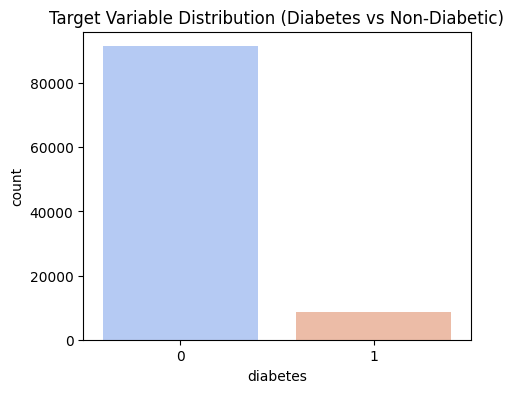

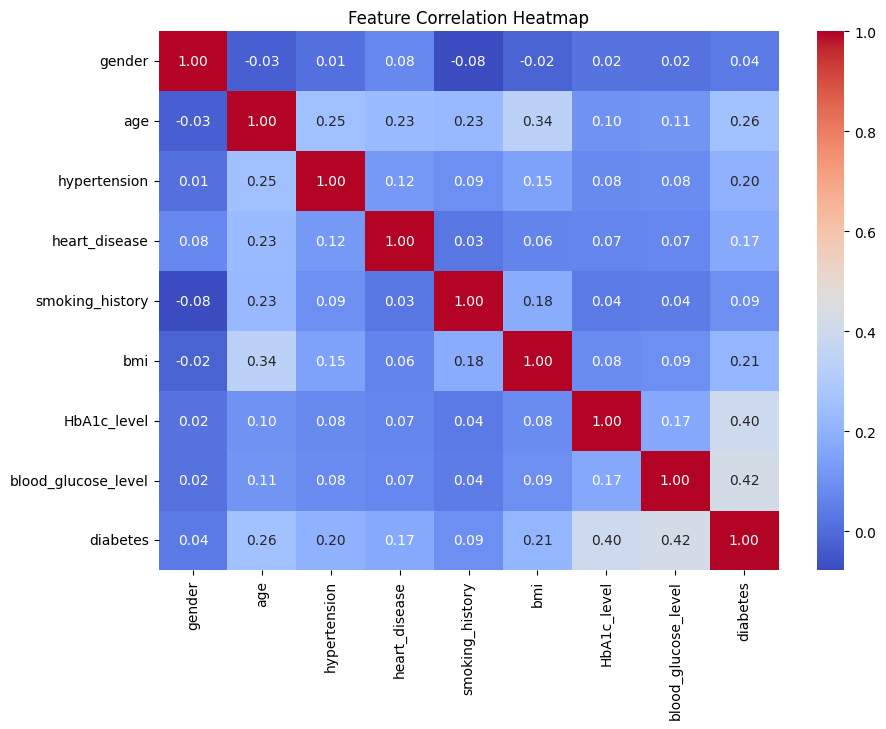

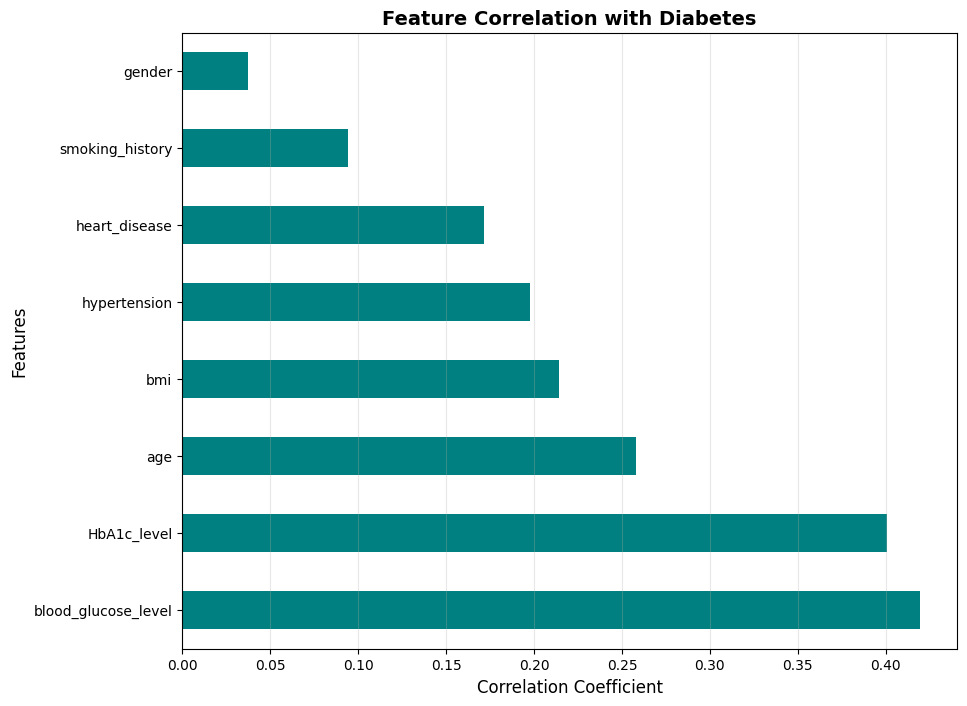

In [6]:
#DATA ANALYSIS (EDA)
#Target distribution
plt.figure(figsize=(5, 4))
sns.countplot(x='diabetes', data=df, palette='coolwarm')
plt.title("Target Variable Distribution (Diabetes vs Non-Diabetic)")
plt.show()

#Correlation heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

#Correlation of features with target
target_corr = df.corr()['diabetes'].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
target_corr.drop('diabetes').plot(kind='barh', color='teal')
plt.title('Feature Correlation with Diabetes', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(alpha=0.3, axis='x')
plt.show()


In [7]:
#FEATURE SELECTION & TRAIN-TEST SPLIT

X = df.drop("diabetes", axis=1)
y = df["diabetes"]

print("\nOriginal class distribution:")
print(Counter(y))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nData Split Completed")
print("Training Size:", X_train.shape)
print("Testing Size:", X_test.shape)

print("\nClass distribution before SMOTE:")
print("Training set:", Counter(y_train))
print("Testing set:", Counter(y_test))



Original class distribution:
Counter({0: 91500, 1: 8500})

Data Split Completed
Training Size: (80000, 8)
Testing Size: (20000, 8)

Class distribution before SMOTE:
Training set: Counter({0: 73200, 1: 6800})
Testing set: Counter({0: 18300, 1: 1700})



Class distribution after SMOTE:
Training set: Counter({1: 73200, 0: 73200})
New Training Size: (146400, 8)


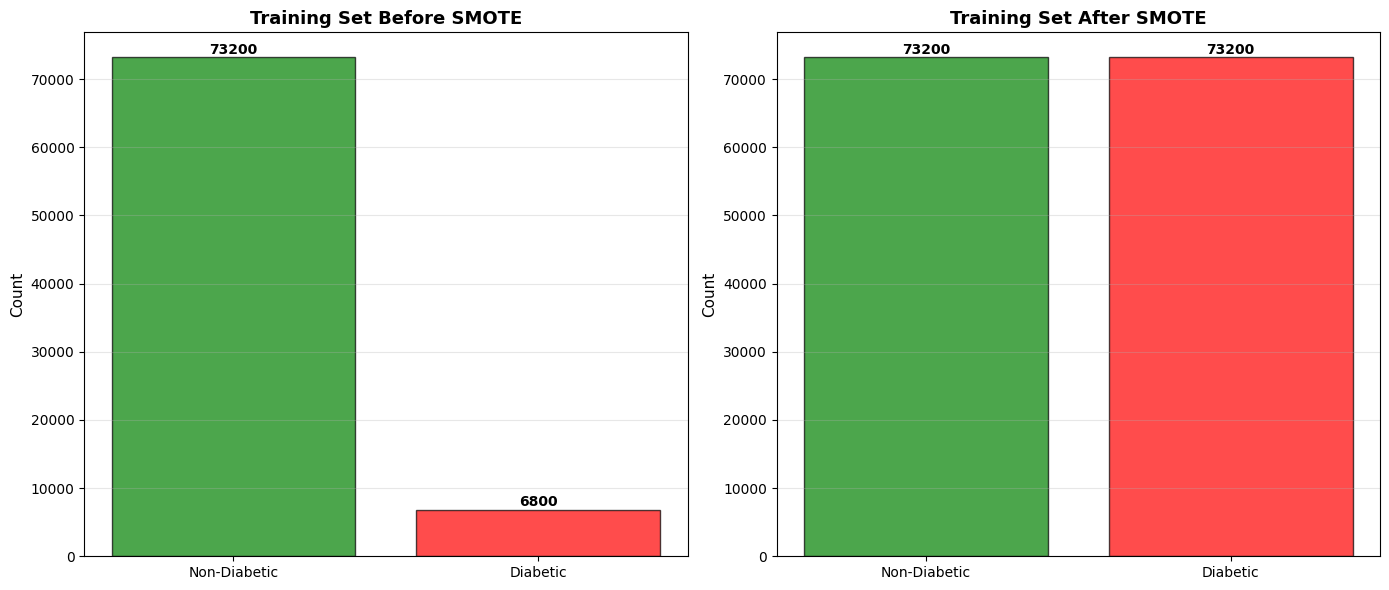

In [8]:
#HANDLE CLASS IMBALANCE WITH SMOTE

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#Before SMOTE visualization
axes[0].bar(['Non-Diabetic', 'Diabetic'],
            [Counter(y_train)[0], Counter(y_train)[1]],
            color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[0].set_title('Training Set Before SMOTE', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=11)
axes[0].grid(alpha=0.3, axis='y')
for i, v in enumerate([Counter(y_train)[0], Counter(y_train)[1]]):
    axes[0].text(i, v + 100, str(v), ha='center', va='bottom', fontweight='bold')

#Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nClass distribution after SMOTE:")
print("Training set:", Counter(y_train_resampled))
print("New Training Size:", X_train_resampled.shape)

#After SMOTE visualization
axes[1].bar(['Non-Diabetic', 'Diabetic'],
            [Counter(y_train_resampled)[0], Counter(y_train_resampled)[1]],
            color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[1].set_title('Training Set After SMOTE', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=11)
axes[1].grid(alpha=0.3, axis='y')
for i, v in enumerate([Counter(y_train_resampled)[0], Counter(y_train_resampled)[1]]):
    axes[1].text(i, v + 100, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [9]:
#FEATURE SCALING

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)  # fit on resampled train
X_test_scaled = scaler.transform(X_test)                  # transform original test



KNN Model Results (with SMOTE)
Accuracy: 0.9003
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     18300
           1       0.45      0.83      0.58      1700

    accuracy                           0.90     20000
   macro avg       0.72      0.87      0.76     20000
weighted avg       0.94      0.90      0.91     20000



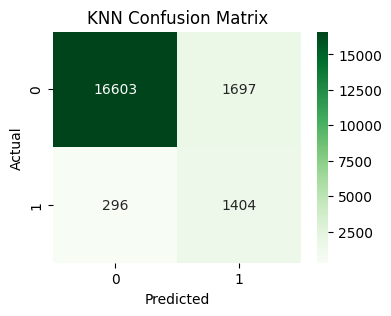

In [11]:
#BASELINE KNN MODEL

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train_resampled)
knn_preds = knn.predict(X_test_scaled)

print("\nKNN Model Results (with SMOTE)")
print("Accuracy:", round(accuracy_score(y_test, knn_preds), 4))
print(classification_report(y_test, knn_preds))

cm = confusion_matrix(y_test, knn_preds)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

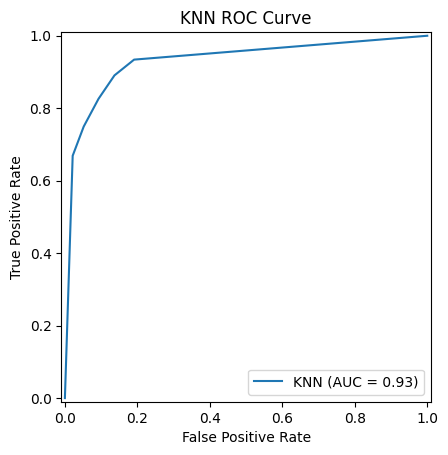

In [12]:
#ROC Curve for KNN
knn_probs = knn.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, knn_probs)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='KNN').plot()
plt.title("KNN ROC Curve")
plt.show()

In [ ]:
#HYPERPARAMETER TUNING FOR KNN

knn_params = {
    "n_neighbors": range(3, 21),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"]
}

knn_random = RandomizedSearchCV(
    KNeighborsClassifier(),
    knn_params,
    n_iter=15,
    cv=3,
    scoring="accuracy",  # can change to "f1" if you want
    n_jobs=-1,
    random_state=42,
    verbose=1
)
knn_random.fit(X_train_scaled, y_train_resampled)

best_knn = knn_random.best_estimator_
print("\nBest KNN Parameters:", knn_random.best_params_)
print("Best Cross-Validation Score:", round(knn_random.best_score_, 4))

best_knn_preds = best_knn.predict(X_test_scaled)
print("Optimized KNN Accuracy:", round(accuracy_score(y_test, best_knn_preds), 4))
print(classification_report(y_test, best_knn_preds))

Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best KNN Parameters: {'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan'}
Best Cross-Validation Score: 0.9395
Optimized KNN Accuracy: 0.9107
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     18300
           1       0.49      0.82      0.61      1700

    accuracy                           0.91     20000
   macro avg       0.73      0.87      0.78     20000
weighted avg       0.94      0.91      0.92     20000




Logistic Regression Results
Accuracy: 0.884
              precision    recall  f1-score   support

           0       0.99      0.89      0.93     18300
           1       0.41      0.87      0.56      1700

    accuracy                           0.88     20000
   macro avg       0.70      0.88      0.75     20000
weighted avg       0.94      0.88      0.90     20000



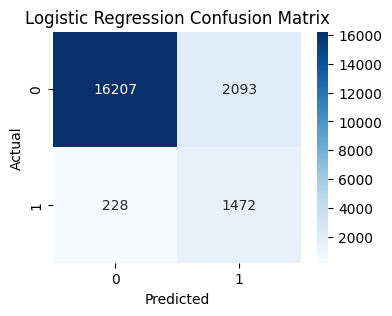

In [15]:
#LOGISTIC REGRESSION MODEL (WITH SMOTE)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train_resampled)
log_preds = log_reg.predict(X_test_scaled)

print("\nLogistic Regression Results")
print("Accuracy:", round(accuracy_score(y_test, log_preds), 4))
print(classification_report(y_test, log_preds))

cm_log = confusion_matrix(y_test, log_preds)
plt.figure(figsize=(4, 3))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

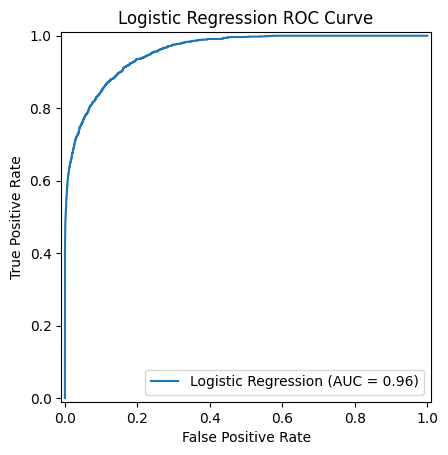

In [16]:
#ROC Curve for Logistic Regression
log_probs = log_reg.predict_proba(X_test_scaled)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test, log_probs)
roc_auc_log = auc(fpr_log, tpr_log)
RocCurveDisplay(fpr=fpr_log, tpr=tpr_log, roc_auc=roc_auc_log,
                estimator_name='Logistic Regression').plot()
plt.title("Logistic Regression ROC Curve")
plt.show()


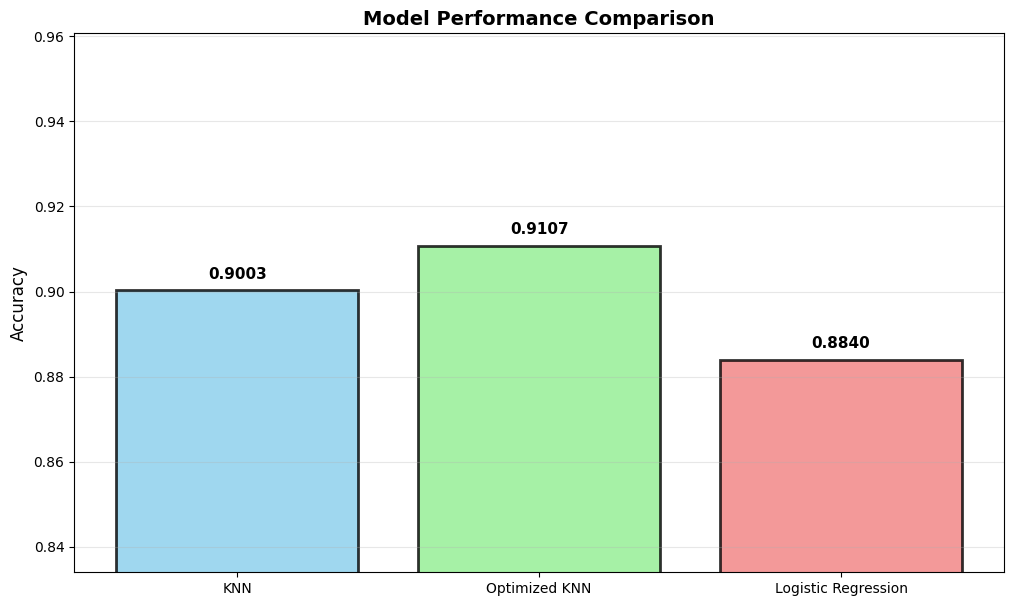

In [17]:
#MODEL PERFORMANCE COMPARISON
models = ['KNN', 'Optimized KNN', 'Logistic Regression']
accuracies = [
    accuracy_score(y_test, knn_preds),
    accuracy_score(y_test, best_knn_preds),
    accuracy_score(y_test, log_preds)
]

plt.figure(figsize=(12, 7))
bars = plt.bar(models, accuracies,
               color=['skyblue', 'lightgreen', 'lightcoral'],
               edgecolor='black', linewidth=2, alpha=0.8)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylim(min(accuracies) - 0.05, max(accuracies) + 0.05)
plt.grid(alpha=0.3, axis='y')
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.002,
             f'{acc:.4f}',
             ha='center', va='bottom', fontweight='bold', fontsize=11)
plt.show()

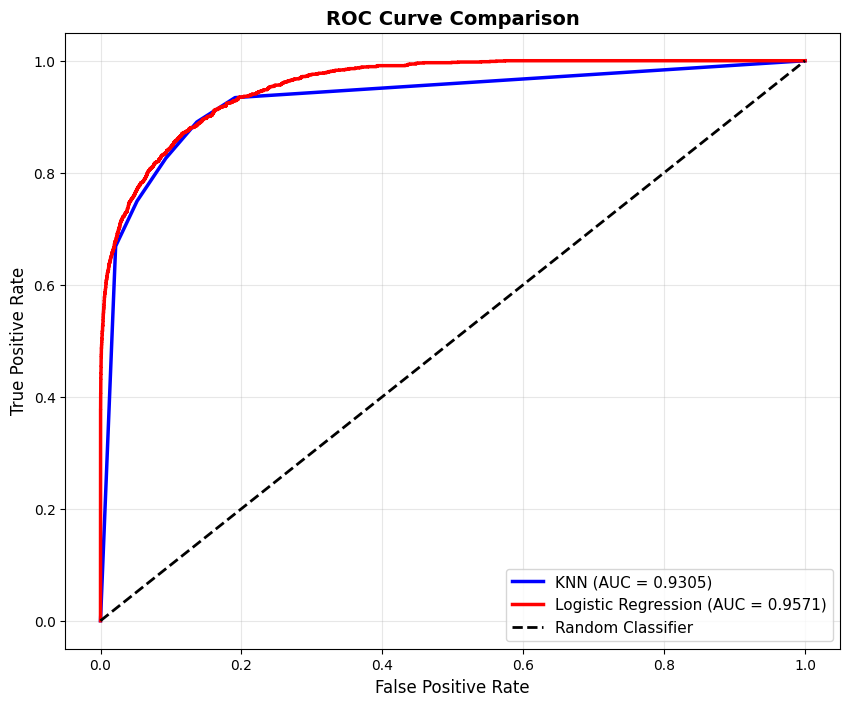

In [18]:
#Combined ROC Curves Comparison
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc:.4f})', linewidth=2.5, color='blue')
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_log:.4f})',
         linewidth=2.5, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.show()


/tmp/ipython-input-904666671.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')


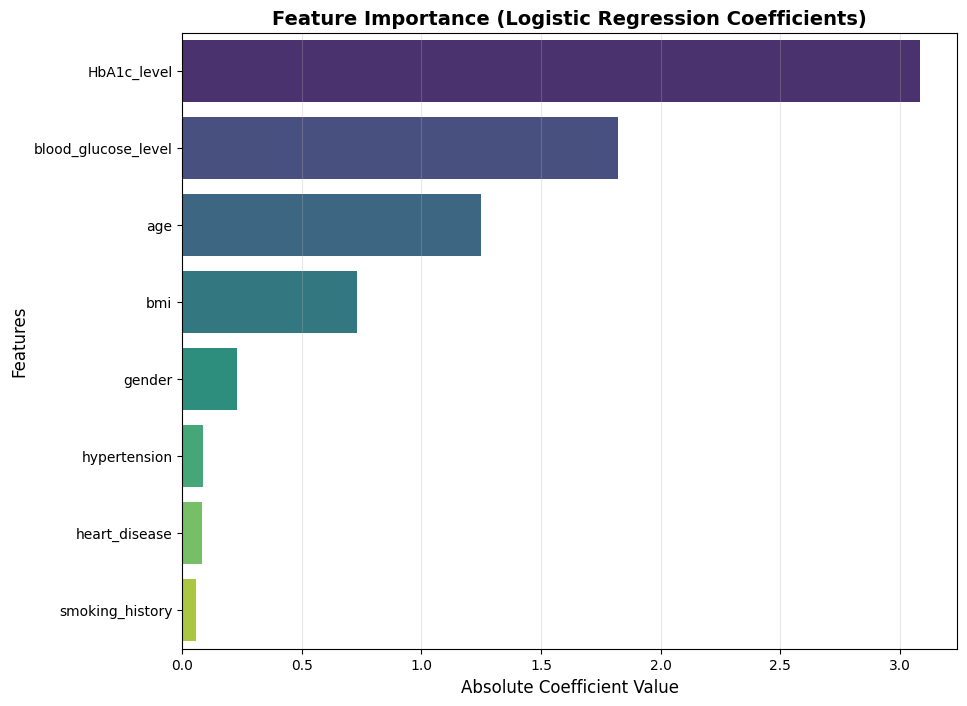

In [19]:
#FEATURE IMPORTANCE (LOGISTIC REGRESSION)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': abs(log_reg.coef_[0])
}).sort_values('Coefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance (Logistic Regression Coefficients)', fontsize=14, fontweight='bold')
plt.xlabel('Absolute Coefficient Value', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(alpha=0.3, axis='x')
plt.show()

In [22]:
#SAVE BEST MODEL AS PICKLE FILE

with open("best_knn_model.pkl", "wb") as f:
    pickle.dump((best_knn, scaler, label_encoders), f)
from google.colab import files
files.download("best_knn_model.pkl")
print("\nModel saved successfully as best_knn_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Model saved successfully as best_knn_model.pkl


In [23]:
#SAMPLE PREDICTION USING SAVED MODEL

with open("best_knn_model.pkl", "rb") as f:
    knn_model, scaler_loaded, label_encoders_loaded = pickle.load(f)

sample = [list(X.iloc[0])]
sample_scaled = scaler_loaded.transform(sample)
prediction = knn_model.predict(sample_scaled)

print("\nSample Prediction Outcome:",
      "Diabetic" if prediction[0] == 1 else "Not Diabetic")


Sample Prediction Outcome: Not Diabetic


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
